## 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib


## 2. Reading the dataset

In [2]:
dataset = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Cleaning the Data

-  Converting total charges into numeric due to missing values and it is recorded as strings
-  Filling the missing values with tenure x Monthly charges instead of other ways
-  Droping customerID because it's not relevant and we don't require it
-  Converting into numeric since we are loading model with logistic, randome forest and xgboost

In [3]:
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['MonthlyCharges'] * dataset['tenure'])

# Drop customerID
dataset.drop("customerID", axis=1, inplace=True)

# Convert target
dataset['Churn'] = dataset['Churn'].map({'Yes':1, 'No':0})

## 4. Encode categorical Variables
- selecting all the columns with the text ie only object columns.
- using get_dummies from pandas does the one-hot like converting text into numeric

In [5]:
categorical_cols = dataset.select_dtypes(include=['object']).columns
dataset = pd.get_dummies(dataset, columns=categorical_cols, drop_first=True)


## 5. Split Data

- using random_state for random splitting
- using stratify to make sure the proportion

In [6]:
X = dataset.drop("Churn", axis=1)
y = dataset["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Scale numeric columns

- Using scaler to make the columns similar range instead of having each column different range.

In [7]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## 7. Fitting Logistic Regression

- fitting the model to predict the probability
- calculating evaluation metrics

In [8]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("ROC AUC:", roc_auc_score(y_test, lr_prob))
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.8062455642299503
ROC AUC: 0.8421710713270816
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



## 8. Fitting Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_prob))
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.7906316536550745
ROC AUC: 0.825911286780852
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



## 9.Fitting XG Boost

In [10]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_prob))
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 0.7899219304471257
ROC AUC: 0.8373944044020769
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



## 10. Identifying key patterns

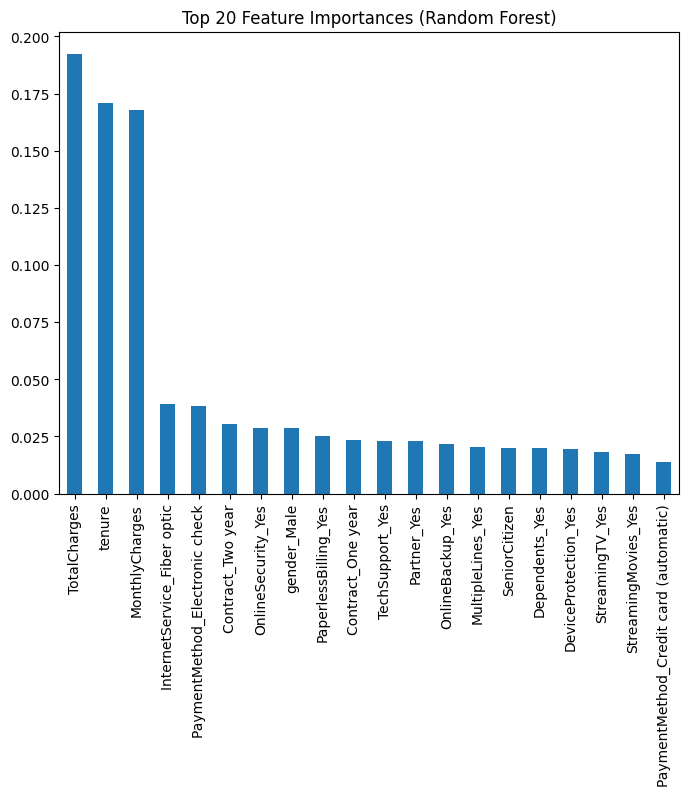

In [11]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
top20.plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

## 11. Saving the trained rf and scaled numeric 

 - It can be used lately, no needed to retrain

In [12]:
joblib.dump(rf, "rf_churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']